Date
ticker
Open
Adj Close


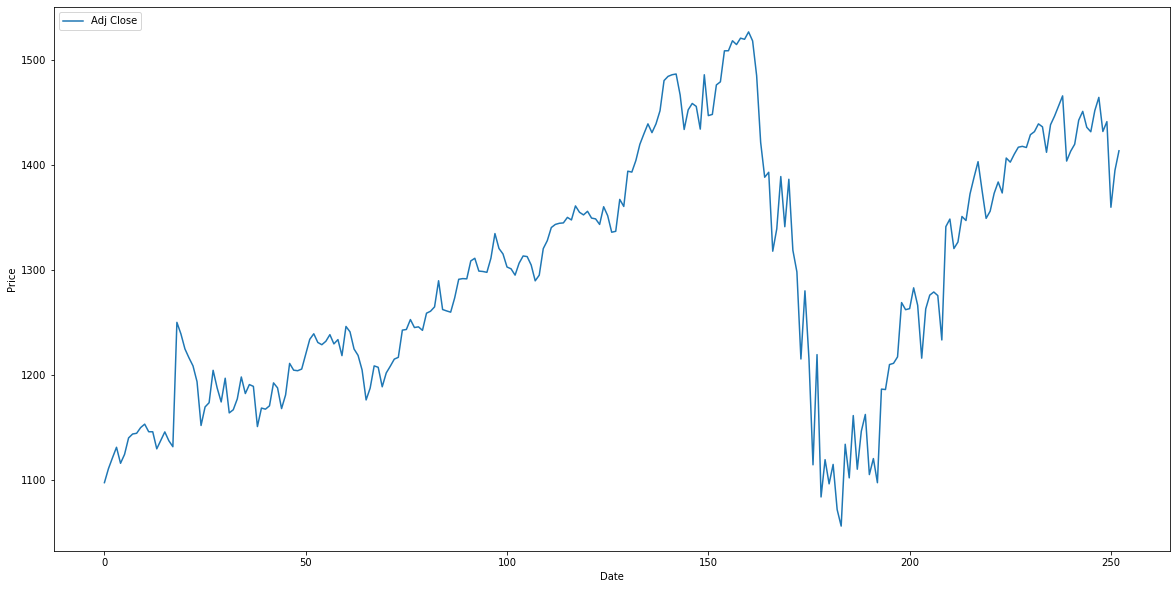

In [83]:

from pandas_datareader import data as wb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
from sklearn.preprocessing import MinMaxScaler

start = '2019-06-30'
end = '2020-06-30'

tickers = ['GOOG']

thelen = len(tickers)

price_data = []
for ticker in tickers:
    prices = wb.DataReader(ticker, start = start, end = end, data_source='yahoo')[['Open','Adj Close']]
    price_data.append(prices.assign(ticker=ticker)[['ticker', 'Open', 'Adj Close']])

#names = np.reshape(price_data, (len(price_data), 1))

df = pd.concat(price_data)
df.reset_index(inplace=True)

for col in df.columns: 
    print(col) 
    
#used for setting the output figure size
rcParams['figure.figsize'] = 20,10
#to normalize the given input data
scaler = MinMaxScaler(feature_range=(0, 1))
#to read input data set (place the file name inside  ' ') as shown below


df['Adj Close'].plot()
plt.legend(loc=2)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()


In [84]:

ntrain = 80
df_train = df.head(int(len(df)*(ntrain/100)))
ntest = -80
df_test = df.tail(int(len(df)*(ntest/100)))


#importing the packages 
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

#dataframe creation
seriesdata = df.sort_index(ascending=True, axis=0)
new_seriesdata = pd.DataFrame(index=range(0,len(df)),columns=['Date','Adj Close'])
length_of_data=len(seriesdata)
for i in range(0,length_of_data):
    new_seriesdata['Date'][i] = seriesdata['Date'][i]
    new_seriesdata['Adj Close'][i] = seriesdata['Adj Close'][i]
#setting the index again
new_seriesdata.index = new_seriesdata.Date
new_seriesdata.drop('Date', axis=1, inplace=True)
#creating train and test sets this comprises the entire data’s present in the dataset
myseriesdataset = new_seriesdata.values
totrain = myseriesdataset[0:255,:]
tovalid = myseriesdataset[255:,:]
#converting dataset into x_train and y_train
scalerdata = MinMaxScaler(feature_range=(0, 1))
scale_data = scalerdata.fit_transform(myseriesdataset)
x_totrain, y_totrain = [], []
length_of_totrain=len(totrain)
for i in range(60,length_of_totrain):
    x_totrain.append(scale_data[i-60:i,0])
    y_totrain.append(scale_data[i,0])
x_totrain, y_totrain = np.array(x_totrain), np.array(y_totrain)
x_totrain = np.reshape(x_totrain, (x_totrain.shape[0],x_totrain.shape[1],1))


In [85]:

#LSTM neural network
lstm_model = Sequential()
lstm_model.add(LSTM(units=50, return_sequences=True, input_shape=(x_totrain.shape[1],1)))
lstm_model.add(LSTM(units=50))
lstm_model.add(Dense(1))
lstm_model.compile(loss='mean_squared_error', optimizer='adadelta')
lstm_model.fit(x_totrain, y_totrain, epochs=10, batch_size=1, verbose=2)
#predicting next data stock price
myinputs = new_seriesdata[len(new_seriesdata) - (len(tovalid)+1) - 60:].values
myinputs = myinputs.reshape(-1,1)
myinputs  = scalerdata.transform(myinputs)
tostore_test_result = []
for i in range(60,myinputs.shape[0]):
    tostore_test_result.append(myinputs[i-60:i,0])
tostore_test_result = np.array(tostore_test_result)
tostore_test_result = np.reshape(tostore_test_result,(tostore_test_result.shape[0],tostore_test_result.shape[1],1))
myclosing_priceresult = lstm_model.predict(tostore_test_result)
myclosing_priceresult = scalerdata.inverse_transform(myclosing_priceresult)
    
totrain = df_train
tovalid = df_test

#predicting next data stock price
myinputs = new_seriesdata[len(new_seriesdata) - (len(tovalid)+1) - 60:].values


Epoch 1/10
 - 14s - loss: 0.0222
Epoch 2/10
 - 11s - loss: 0.0109
Epoch 3/10
 - 10s - loss: 0.0086
Epoch 4/10
 - 11s - loss: 0.0070
Epoch 5/10
 - 11s - loss: 0.0076
Epoch 6/10
 - 12s - loss: 0.0069
Epoch 7/10
 - 12s - loss: 0.0067
Epoch 8/10
 - 12s - loss: 0.0059
Epoch 9/10
 - 12s - loss: 0.0061
Epoch 10/10
 - 12s - loss: 0.0059


In [86]:

#  Printing the next day’s predicted stock price. 
print(len(tostore_test_result));
print(myclosing_priceresult);


1
[[1396.532]]


In [ ]:

# Final Conclusion: This analysis was done on 06/30/2020; we want to predict the next day's closing price for GOOG.  After running 10 epochs, we see that themodel has predicted a closing price of 1396.53 for GOOG on 07/01/2020.  The actual closing price for GOOG on 07/01/2020 was 1,438.04.  The difference is around 3%; the stock actually performed around 3% better than what the model predicted.  To improve overall performance, we can collect more data, run more epochs, or tune the model slightly differently. 
    